In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import yaml
import math
import json
import matplotlib as mpl
import matplotlib.cm
import matplotlib.colors
%matplotlib inline

In [26]:
def setFontsize(fontSize, ax=ax):
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontSize)
    return ax

In [3]:
train = pd.read_csv("./data/all/train.csv")

In [4]:
train.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [5]:
train.shape

(32769, 10)

In [6]:
len(train) == len(train.drop_duplicates())

True

In [7]:
train.isnull().sum()

ACTION              0
RESOURCE            0
MGR_ID              0
ROLE_ROLLUP_1       0
ROLE_ROLLUP_2       0
ROLE_DEPTNAME       0
ROLE_TITLE          0
ROLE_FAMILY_DESC    0
ROLE_FAMILY         0
ROLE_CODE           0
dtype: int64

Binary classificaiton problem - what is the distribution of the target variable?

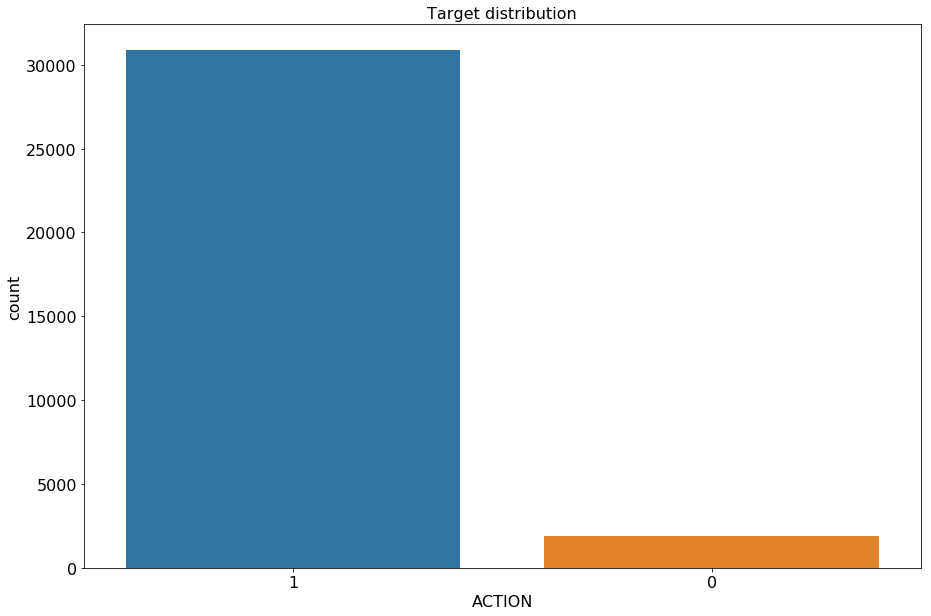

In [8]:
plt.figure(figsize=(15,10))
ax = sns.countplot(train["ACTION"],order=[1,0])
ax.set(title="Target distribution")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)
plt.show()

Massive class imbalance - most resources seem to be approved! Might need to consider under/ over sampling....

In [9]:
train.apply(pd.Series.nunique, axis=0)

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

Resources can apply multiple times it seems as well

In [12]:
nEmployees = 20

In [27]:
df = train.groupby(["RESOURCE"]).size().sort_values(ascending=False).rename("accessCount").head(nEmployees)
#df["RESOURCE"] = df["RESOURCE"].astype(str)
plt.figure(figsize=(15,10))
ax = sns.barplot(x="RESOURCE", y="accessCount",data=df)
ax.set(title="Access count for top "+str(nEmployees)+ " employees")
setFontsize(16)
plt.show()

ValueError: Could not interpret input 'RESOURCE'

What about the number of employees that fall under a manager?

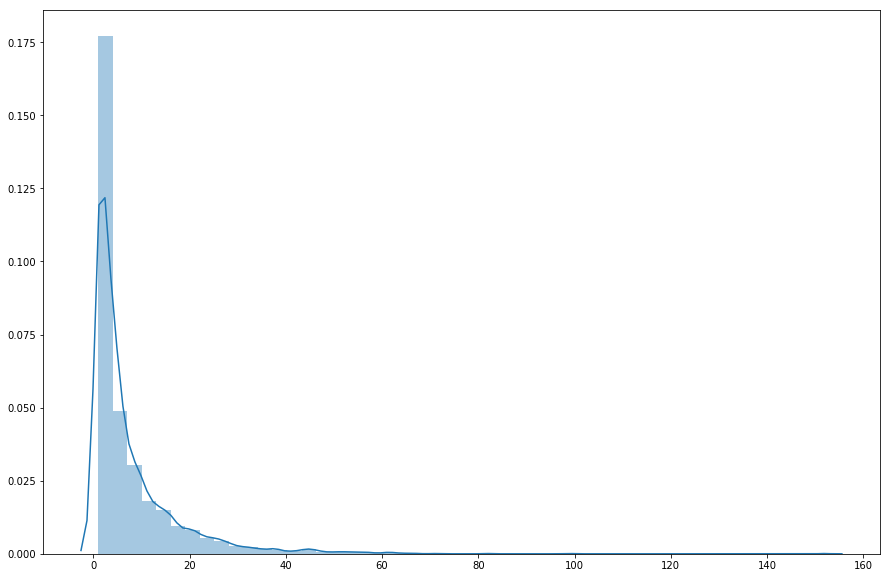

In [32]:
plt.figure(figsize=(15,10))
ax = sns.distplot(train.groupby(["MGR_ID"]).size())
setFontsize(15)
plt.show()

Very skewed distribution. Most managers have <10 employees reporting into them and maximum being ~ 100. The cavaet here though is that we are assuming each record refers to a unique employee, however an employee might be able to make multiple requests. As there is no UUID for employee this will have to do...
Does the number of employees reporting into a manager influence the action outcome? If a manager has a large number of employees reporting into s/he then they could potentially have a larger staff turnover and making more frequent requests

In [56]:
tmp = train.copy()
managerRank = pd.qcut(train.groupby(["MGR_ID"]).size().rank(method='first'), 10, labels=range(0,10)).rename("employeeCountRank").reset_index()
tmp = pd.merge(tmp, managerRank, on=["MGR_ID"])
tmp = tmp.groupby(["employeeCountRank","ACTION"]).size()
tmp = tmp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).rename("prop").reset_index()

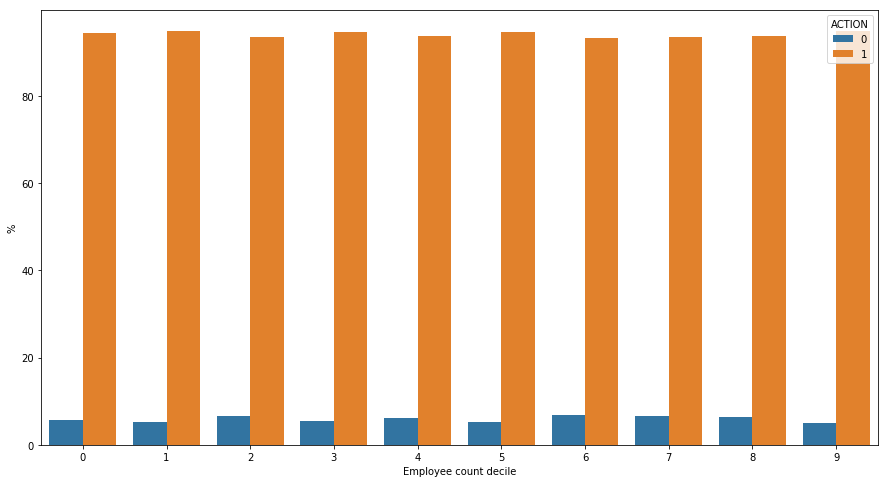

In [69]:
plt.figure(figsize=(15,8))
ax = sns.barplot(x="employeeCountRank", y="prop", hue="ACTION", data=tmp)
ax.set(title="",xlabel="Employee count decile", ylabel="%")
ax=setFontsize(10)
plt.show()

Nothing to see here move along

In [71]:
train["ROLE_FAMILY"]

0        290919
1        308574
2         19721
3        290919
4         19793
5         19721
6        118295
7        118638
8          4673
9         19721
10       290919
11       119095
12       118960
13       118205
14       290919
15       117887
16       290919
17       118704
18       290919
19       290919
20       118424
21       290919
22       308574
23       290919
24       290919
25       290919
26       290919
27       117887
28        19721
29       118424
          ...  
32739     19721
32740    290919
32741    290919
32742    119184
32743    290919
32744    290919
32745    308574
32746    290919
32747    118424
32748    120518
32749    118398
32750    290919
32751    290919
32752    121069
32753     19793
32754    117887
32755    290919
32756    118295
32757    118131
32758    120518
32759    118453
32760    119095
32761    290919
32762    118424
32763    290919
32764    290919
32765    249618
32766    118612
32767    292795
32768     19721
Name: ROLE_FAMILY, Lengt